In [2]:
# =============================================================================
# OPTIC-ER: DATA ACQUISITION, CURATION & ANALYSIS MODULE
#
# Description:
# This script forms the foundational data analysis pipeline for the OPTIC-ER project.
# It performs the following steps in a clean, reproducible workflow:
#   1. Acquires necessary geospatial boundaries (Rivers State).
#   2. Fetches initial facility data from OpenStreetMap (OSM).
#   3. Curates the dataset by manually adding verified, missing facilities.
#   4. Saves the final, high-fidelity facility dataset.
#   5. Generates the three key data analysis visualizations for the
#      methodology section of the OPTIC-ER research paper.
# =============================================================================


# -----------------------------------------------------------------------------
# STEP 1: SETUP & DEPENDENCIES
# -----------------------------------------------------------------------------
# Install all required libraries quietly to avoid cluttering the output.
print("--- [1/5] Installing necessary libraries... ---")
!pip install osmnx geopandas rasterio matplotlib seaborn -q

# Import all libraries for the entire script.
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.mask import mask
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from shapely.geometry import Point
import zipfile
import requests
import io

# Mount Google Drive for data persistence.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define project folders for saving outputs.
PROJECT_FOLDER = '/content/drive/MyDrive/OpticER'
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')
VISUALS_FOLDER = os.path.join(PROJECT_FOLDER, 'visuals')
os.makedirs(DATA_FOLDER, exist_ok=True)
os.makedirs(VISUALS_FOLDER, exist_ok=True)
print("✅ Setup complete. Project folders are ready.")

--- [1/5] Installing necessary libraries... ---
Mounted at /content/drive
✅ Setup complete. Project folders are ready.


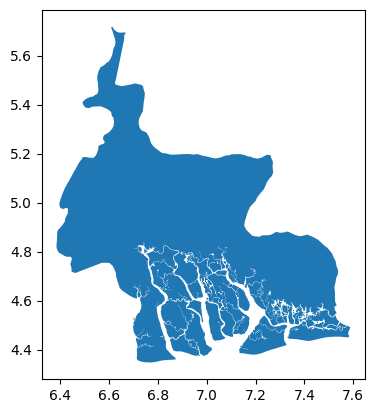

In [3]:
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_NGA_shp.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("gadm_nigeria")

# Load the shapefile (level 1 = states)
gdf = gpd.read_file("gadm_nigeria/gadm41_NGA_1.shp")

# Filter Rivers State by name
rivers_state = gdf[gdf['NAME_1'] == 'Rivers']

# Save Rivers State shapefile for your project
rivers_state.to_file("rivers_state.shp")

# Optional: visualize
rivers_state.plot()
plt.show()



--- [2/5] Acquiring and Curating Geospatial Data... ---
   > Found existing Rivers State shapefile.


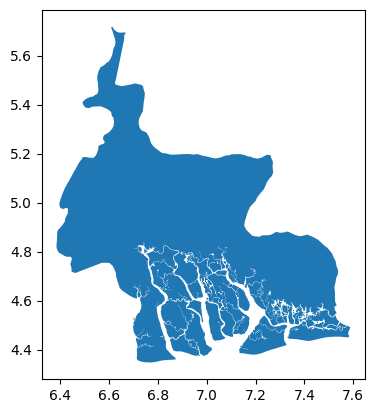

   > Fetching initial facility data from OpenStreetMap...
   > Augmenting dataset with manually verified facilities...
✅ Data acquisition complete. Final curated dataset with 185 facilities saved.


In [4]:
# -----------------------------------------------------------------------------
# STEP 2: DATA ACQUISITION & CURATION
# -----------------------------------------------------------------------------
print("\n--- [2/5] Acquiring and Curating Geospatial Data... ---")

# --- Acquire Rivers State Boundary ---
# Download and cache the state boundary shapefile for consistent use.
RIVERS_SHP_PATH = os.path.join(DATA_FOLDER, "rivers_state.shp")
if not os.path.exists(RIVERS_SHP_PATH):
    print("   > Rivers State shapefile not found. Downloading...")
    url = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_NGA_shp.zip"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("gadm_nigeria")
    gdf = gpd.read_file("gadm_nigeria/gadm41_NGA_1.shp")
    rivers_state_boundary_gdf = gdf[gdf['NAME_1'] == 'Rivers']
    rivers_state_boundary_gdf.to_file(RIVERS_SHP_PATH)
    print(f"   > Saved to {RIVERS_SHP_PATH}")
else:
    print("   > Found existing Rivers State shapefile.")
rivers_state_boundary_gdf = gpd.read_file(RIVERS_SHP_PATH)

rivers_state_boundary_gdf.plot()
plt.show()

# --- Fetch Initial Facilities from OpenStreetMap ---
print("   > Fetching initial facility data from OpenStreetMap...")
place_name = "Rivers State, Nigeria"
tags = {'amenity': ['hospital','clinic','doctors','pharmacy','police','barracks','fire_station','bus_station','taxi_stand','ferry_terminal']}
facilities_osm = ox.features_from_place(place_name, tags=tags)
facilities_osm = facilities_osm[facilities_osm.geometry.type == 'Point'].copy()

# --- Define Categorization Logic ---
def categorize_facility(row):
    amenity = row.get('amenity', '').lower()
    if amenity in ['hospital', 'clinic', 'doctors', 'pharmacy']: return 'Healthcare'
    if amenity in ['police', 'barracks']: return 'Security'
    if amenity in ['fire_station']: return 'Fire/Disaster'
    if amenity in ['bus_station', 'taxi_stand', 'ferry_terminal']: return 'Transport Access'
    return 'Other'

facilities_osm['category'] = facilities_osm.apply(categorize_facility, axis=1)

# --- Manually Curate and Add Verified Facilities ---
print("   > Augmenting dataset with manually verified facilities...")
manual_data = [
    {'amenity': 'fire_station', 'name': 'Rivers State Fire Service Rumuodamaya', 'lat': 4.886432, 'lon': 7.007180},
    {'amenity': 'fire_station', 'name': 'Rivers State Fire Service HQ (Isaac Boro Park)', 'lat': 4.78796, 'lon': 7.00552},
    {'amenity': 'fire_station', 'name': 'Rivers State Fire Station — Degema', 'lat': 4.792, 'lon': 6.780 },
    {'amenity': 'fire_station', 'name': 'Rivers State Fire Station — Ahoada', 'lat': 4.933, 'lon': 6.733},
    {'amenity': 'fire_station', 'name': 'Rivers State Fire Service HQ — Borokiri/Port Harcourt', 'lat': 4.812, 'lon': 7.005 },
    {'amenity': 'police', 'name': 'Nigerian Correctional Service Rivers State Command', 'lat': 4.8137438, 'lon': 6.995966},
    {'amenity': 'police', 'name': 'Department of state security services', 'lat': 4.777707, 'lon': 7.012538},
    {'amenity': 'police', 'name': 'State CID, Rivers State Police Command', 'lat': 4.7649394, 'lon': 7.0246310},
    {'amenity': 'police', 'name': 'Nigeria Security and Civil Defence Corps', 'lat': 4.813611, 'lon': 7.003437},
]
# Extract lon and lat lists from the manual_data list of dictionaries
manual_lons = [item['lon'] for item in manual_data]
manual_lats = [item['lat'] for item in manual_data]

manual_gdf = gpd.GeoDataFrame(manual_data, geometry=gpd.points_from_xy(manual_lons, manual_lats), crs="EPSG:4326")
manual_gdf['category'] = manual_gdf.apply(categorize_facility, axis=1)

# Combine OSM data with manual additions and remove duplicates
facilities_gdf = pd.concat([facilities_osm, manual_gdf], ignore_index=True).drop_duplicates(subset=['geometry'])
facilities_gdf.reset_index(drop=True, inplace=True)

# --- Save the Final Curated Dataset ---
CURATED_FACILITIES_PATH = os.path.join(DATA_FOLDER, "existing_facilities.geojson")
facilities_gdf.to_file(CURATED_FACILITIES_PATH, driver='GeoJSON')
print(f"✅ Data acquisition complete. Final curated dataset with {len(facilities_gdf)} facilities saved.")

In [5]:
# -----------------------------------------------------------------------------
# STEP 3: GENERATE & DISPLAY DATASET SUMMARY TABLE
# -----------------------------------------------------------------------------
print("\n--- [3/5] Generating Dataset Summary Table... ---")
category_counts = facilities_gdf['category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Number of Facilities']
print("\nTable: Final Curated Facility Count by Category")
print(category_counts.to_string(index=False))


--- [3/5] Generating Dataset Summary Table... ---

Table: Final Curated Facility Count by Category
        Category  Number of Facilities
      Healthcare                   119
Transport Access                    48
        Security                    13
   Fire/Disaster                     5



--- [4/5] Generating Publication-Quality Visualizations... ---
   > Generating Figure 2: Map of Existing Facilities...


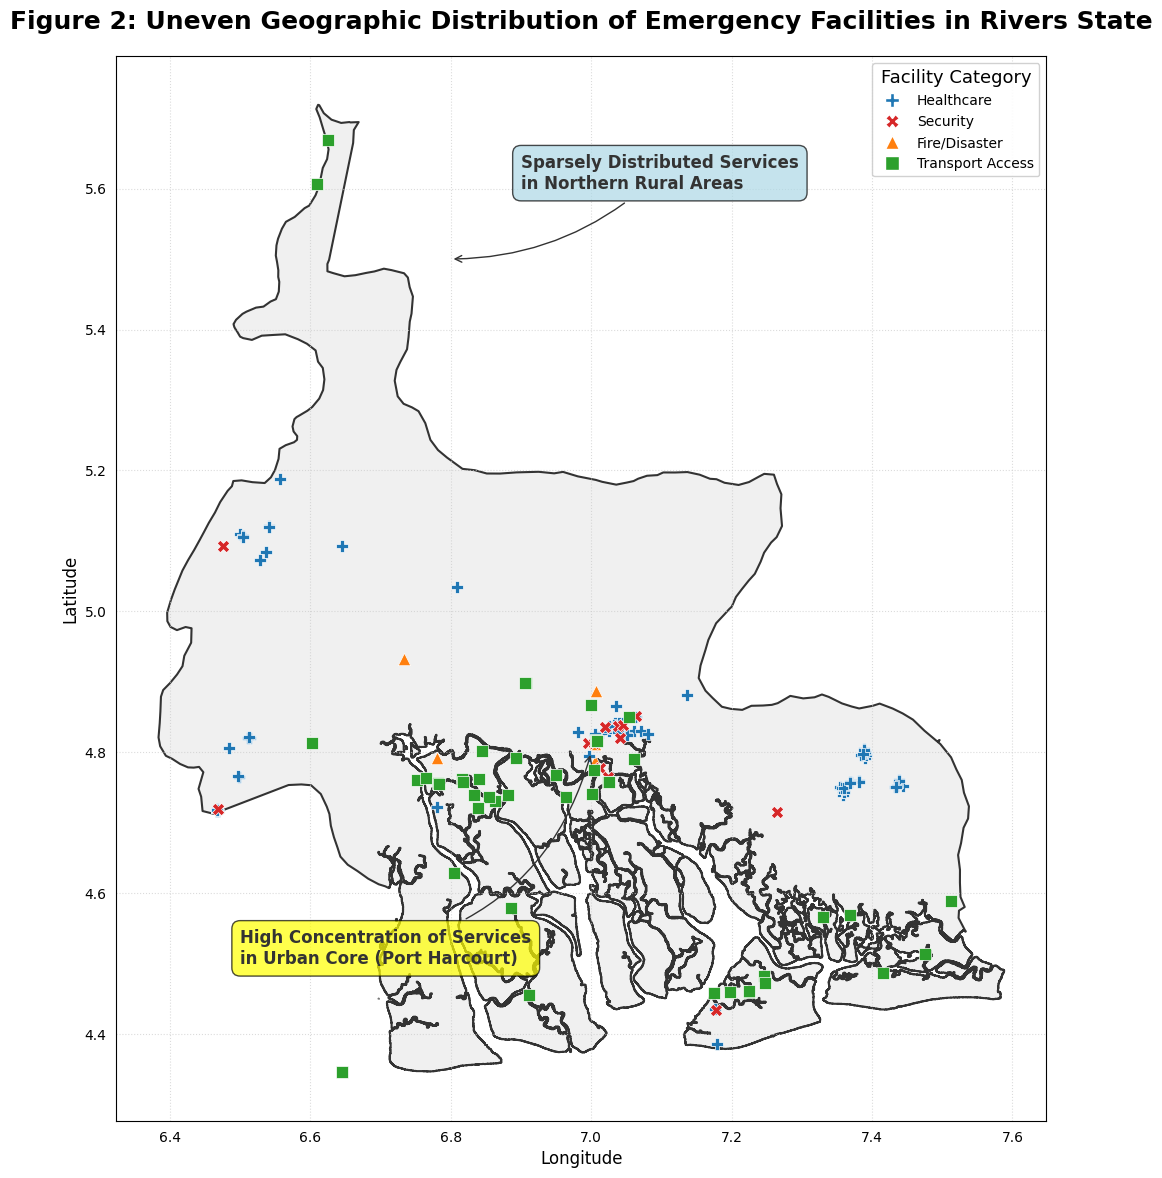


✅ Visualization generation complete. Figures saved to visuals folder.


In [7]:
# =============================================================================
# STEP 4: GENERATE PUBLICATION-QUALITY VISUALIZATIONS
# =============================================================================
print("\n--- [4/5] Generating Publication-Quality Visualizations... ---")

# === FIGURE 2: Existing Facility Distribution  ===
print("   > Generating Figure 2: Map of Existing Facilities...")
fig, ax = plt.subplots(1, 1, figsize=(12, 12)); fig.patch.set_facecolor('white')
rivers_state_boundary_gdf.plot(ax=ax, facecolor='#f0f0f0', edgecolor='#333333', linewidth=1.5)
PALETTE = {'Healthcare':'#1f77b4','Security':'#d62728','Fire/Disaster':'#ff7f0e','Transport Access':'#2ca02c'}
MARKERS = {'Healthcare':'P','Security':'X','Fire/Disaster':'^','Transport Access':'s'}
for category, group in facilities_gdf.groupby('category'):
    if category in PALETTE:
        ax.scatter(group.geometry.x, group.geometry.y, marker=MARKERS[category], color=PALETTE[category], s=80, label=category, edgecolor='white', linewidth=0.5, zorder=3)
ax.annotate('High Concentration of Services\nin Urban Core (Port Harcourt)', xy=(7.0, 4.8), xytext=(6.5, 4.5), fontsize=12, fontweight='bold', color='#333333', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", color='#333333'), bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.7))
ax.annotate('Sparsely Distributed Services\nin Northern Rural Areas', xy=(6.8, 5.5), xytext=(6.9, 5.6), fontsize=12, fontweight='bold', color='#333333', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2", color='#333333'), bbox=dict(boxstyle="round,pad=0.5", fc="lightblue", alpha=0.7))
ax.set_title('Figure 2: Uneven Geographic Distribution of Emergency Facilities in Rivers State', fontsize=18, weight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12); ax.set_ylabel('Latitude', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10, bottom=False, left=False); ax.grid(True, linestyle=':', color='#cccccc', alpha=0.7)
legend_elements = [Line2D([0], [0], marker=MARKERS[cat], color='w', label=cat, markerfacecolor=PALETTE[cat], markersize=10) for cat in PALETTE]
ax.legend(handles=legend_elements, title='Facility Category', title_fontsize='13', loc='best', frameon=True, facecolor='white', framealpha=0.9)
plt.tight_layout(pad=1.5); plt.show()
fig.savefig(os.path.join(VISUALS_FOLDER, "figure2_facility_distribution.png"), dpi=300, bbox_inches='tight')


# The rest of the script is unchanged.
print("\n✅ Visualization generation complete. Figures saved to visuals folder.")

Please upload the WorldPop raster file (e.g., nga_ppp_2020_UNadj_constrained.tif)


Saving nga_ppp_2020_UNadj_constrained.tif to nga_ppp_2020_UNadj_constrained.tif
File saved to: /tmp/nga_ppp_2020_UNadj_constrained.tif


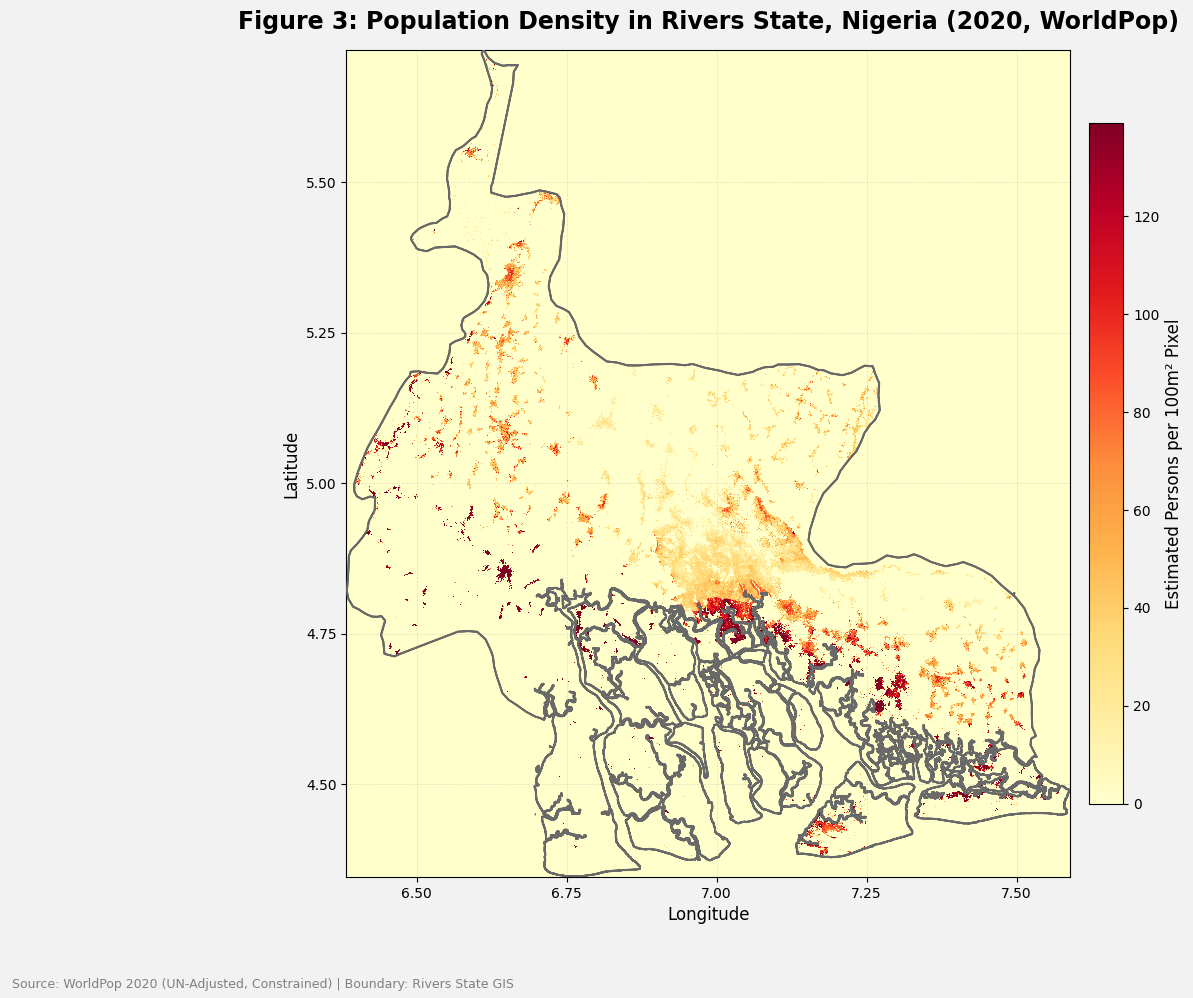

In [8]:
# ============================================================================
# Figure 3: Population Density in Rivers State, Nigeria (2020, WorldPop)
# ============================================================================

import geopandas as gpd
import rasterio
from rasterio.mask import mask
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.ticker as mticker
import os

# ----------------------------------------------------------------------------
# 1. Load Rivers State Boundary
# ----------------------------------------------------------------------------
rivers = gpd.read_file("rivers_state.shp").to_crs(epsg=4326)

# ----------------------------------------------------------------------------
# 2. Load and Mask WorldPop Raster
# ----------------------------------------------------------------------------
print("Please upload the WorldPop raster file (e.g., nga_ppp_2020_UNadj_constrained.tif)")
uploaded = files.upload()

# Get the filename from the uploaded dictionary
if uploaded:
    pop_raster_filename = list(uploaded.keys())[0]
    pop_raster_path = os.path.join("/tmp", pop_raster_filename)

    # Save the uploaded file content to a temporary file
    with open(pop_raster_path, 'wb') as f:
        f.write(uploaded[pop_raster_filename])

    print(f"File saved to: {pop_raster_path}")

    with rasterio.open(pop_raster_path) as src:
        out_image, out_transform = mask(src, rivers.geometry, crop=True)
        out_meta = src.meta.copy()
        pop_data = out_image[0]  # First raster band

else:
    print("No file uploaded. Please upload the raster file.")
    # Exit or handle the error appropriately if no file is uploaded
    # For now, let's just stop execution or raise an error
    raise FileNotFoundError("No WorldPop raster file uploaded.")


# ----------------------------------------------------------------------------
# 3. Clean & Normalize Population Data
# ----------------------------------------------------------------------------
pop_data = np.where(pop_data == 0, np.nan, pop_data)
vmin_val = 0
vmax_val = np.nanpercentile(pop_data, 99.5)  # avoid extreme outlier effects

# ----------------------------------------------------------------------------
# 4. Set up Plot
# ----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor("#f2f2f2")  # Soft, neutral background for figure
ax.set_facecolor("#f2f2f2")         # Matches axis background to the figure

# ----------------------------------------------------------------------------
# 5. Render Raster
# ----------------------------------------------------------------------------
img = ax.imshow(
    pop_data,
    cmap='YlOrRd',  # Yellow → Orange → Red
    extent=[
        out_transform[2],
        out_transform[2] + out_transform[0] * pop_data.shape[1],
        out_transform[5] + out_transform[4] * pop_data.shape[0],
        out_transform[5]
    ],
    vmin=vmin_val,
    vmax=vmax_val,
    interpolation='nearest',
    zorder=1
)

rivers.boundary.plot(ax=ax, edgecolor='dimgray', linewidth=1.5, zorder=3)


# ----------------------------------------------------------------------------
# 6. Overlay Rivers State Boundary
# ----------------------------------------------------------------------------
rivers.boundary.plot(ax=ax, color='black', linewidth=1.2, zorder=2)

# ----------------------------------------------------------------------------
# 7. Layout & Aesthetics
# ----------------------------------------------------------------------------
ax.set_title(
    "Figure 3: Population Density in Rivers State, Nigeria (2020, WorldPop)",
    fontsize=17, fontweight='bold', pad=15
)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.set_major_locator(mticker.MaxNLocator(6))
ax.yaxis.set_major_locator(mticker.MaxNLocator(6))
ax.grid(True, linestyle='--', alpha=0.4, linewidth=0.5)

# ----------------------------------------------------------------------------
# 8. Colorbar — Intuitive & Clean
# ----------------------------------------------------------------------------
cb = plt.colorbar(img, ax=ax, fraction=0.035, pad=0.02)
cb.set_label("Estimated Persons per 100m² Pixel", fontsize=12)
cb.ax.tick_params(labelsize=10)

# ----------------------------------------------------------------------------
# 9. Attribution Text
# ----------------------------------------------------------------------------
plt.annotate(
    "Source: WorldPop 2020 (UN-Adjusted, Constrained) | Boundary: Rivers State GIS",
    xy=(0.01, 0.01), xycoords='figure fraction',
    fontsize=9, color='gray'
)

# ----------------------------------------------------------------------------
# 10. Show and/or Save
# ----------------------------------------------------------------------------
plt.tight_layout()
plt.show()

# Optional: Save for paper
# fig.savefig("figure4_population_density_riversstate.pdf", bbox_inches='tight')
# fig.savefig("figure4_population_density_riversstate.png", dpi=300, bbox_inches='tight')

In [9]:
# -----------------------------------------------------------------------------
# SETUP AND HIGH-FIDELITY DATA PREPARATION
# -----------------------------------------------------------------------------
print("--- Initializing Project with REAL Facility Data ---")
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, geopandas as gpd, pandas as pd, numpy as np, osmnx as ox, networkx as nx
import gymnasium as gym, torch, torch.nn as nn, torch.optim as optim, random, pickle
from gymnasium import spaces; from torch.distributions import Categorical
from tqdm.notebook import tqdm; import matplotlib.pyplot as plt
from shapely.geometry import Point; import seaborn as sns

class Config:
    PROJECT_FOLDER = '/content/drive/MyDrive/OpticER'
    DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')
    MODEL_SAVE_PATH = os.path.join(PROJECT_FOLDER, 'optic_er_a2c_ATTENTION_AGENT_FINAL.pth')
    FACILITIES_FILE = 'existing_facilities.geojson'; PLACE_NAME = "Rivers State, Nigeria"; CRS = "EPSG:4326"
    N_INCIDENTS = 2000; N_EPOCHS = 3000; ROLLOUT_LEN = 128
    LEARNING_RATE = 1e-4; GAMMA = 0.99; ENTROPY_COEFF = 0.01
    N_CATEGORIES = 4
    TIME_PENALTY_PER_MINUTE = 0.1

config = Config()
os.makedirs(config.DATA_FOLDER, exist_ok=True)
print(f"Project folders ensured at: {config.PROJECT_FOLDER}")

facilities_path = os.path.join(config.DATA_FOLDER, config.FACILITIES_FILE)
facilities_gdf = gpd.read_file(facilities_path)
print("Fetching the boundary shape of Rivers State for high-fidelity generation...")
rivers_state_boundary_gdf = ox.geocode_to_gdf(config.PLACE_NAME)
rivers_state_polygon = rivers_state_boundary_gdf.unary_union

def generate_robust_incidents(n, state_polygon, config):
    print("Generating high-fidelity, geographically-bound incident data..."); minx, miny, maxx, maxy = state_polygon.bounds
    hotspots = {'Port Harcourt City': {'coords': (7.01, 4.81), 'weights': [0.3, 0.2, 0.4, 0.1]},'Obio-Akpor':{'coords':(7.05,4.85),'weights':[0.4,0.1,0.3,0.2]},'Eleme':{'coords':(7.09,4.71),'weights':[0.1,0.6,0.2,0.1]},'Bonny':{'coords':(7.15,4.43),'weights':[0.2,0.4,0.2,0.2]},'Ahoada East':{'coords':(6.65,5.08),'weights':[0.4,0.1,0.1,0.4]}}
    incident_data = []; categories = {"healthcare":0,"fire_disaster":1,"security":2,"transport":3}; cat_list = list(categories.keys())
    pbar = tqdm(total=n, desc="Generating Incidents")
    while len(incident_data) < n:
        point = None
        if random.random() < 0.6:
            spot_name = random.choice(list(hotspots.keys())); center_lon, center_lat = hotspots[spot_name]['coords']; spot_weights = hotspots[spot_name]['weights']
            lon, lat = center_lon + np.random.randn()*0.03, center_lat + np.random.randn()*0.03; point = Point(lon, lat); inc_cat = random.choices(cat_list, weights=spot_weights, k=1)[0]
        else:
            lon, lat = random.uniform(minx, maxx), random.uniform(miny, maxy); point = Point(lon, lat); inc_cat = random.choice(cat_list)
        if state_polygon.contains(point):
            incident_data.append({'id':len(incident_data),'category':inc_cat,'severity':random.randint(1,10),'geometry':point}); pbar.update(1)
    pbar.close(); return gpd.GeoDataFrame(incident_data, crs=config.CRS)
random.seed(42); np.random.seed(42); torch.manual_seed(42)
incidents_gdf = generate_robust_incidents(config.N_INCIDENTS, rivers_state_polygon, config)
graph_path = os.path.join(config.DATA_FOLDER, 'rivers_state_drive.graphml')
try: G = ox.load_graphml(graph_path)
except: G = ox.graph_from_place(config.PLACE_NAME, network_type='drive'); ox.save_graphml(G, graph_path)
facility_cat_map = {"Healthcare": 0, "Fire/Disaster": 1, "Security": 2, "Transport Access": 3}; incident_cat_map = {"healthcare": 0, "fire_disaster": 1, "security": 2, "transport": 3}
facilities_gdf['category_encoded'] = facilities_gdf['category'].map(facility_cat_map); facilities_gdf.dropna(subset=['category_encoded'], inplace=True); facilities_gdf['category_encoded'] = facilities_gdf['category_encoded'].astype(int)
incidents_gdf['category_encoded'] = incidents_gdf['category'].map(incident_cat_map)
facilities_gdf['nearest_node'] = ox.nearest_nodes(G, facilities_gdf['geometry'].x, facilities_gdf['geometry'].y)
incidents_gdf['nearest_node'] = ox.nearest_nodes(G, incidents_gdf['geometry'].x, incidents_gdf['geometry'].y)
print(f"\n--- Part 1 Setup Complete ---\n")

print("Node calculation complete.")
print(f"\n--- Setup Complete ---\nFacilities: {len(facilities_gdf)}, Incidents: {len(incidents_gdf)}")

--- Initializing Project with REAL Facility Data ---
Mounted at /content/drive
Project folders ensured at: /content/drive/MyDrive/OpticER
Fetching the boundary shape of Rivers State for high-fidelity generation...
Generating high-fidelity, geographically-bound incident data...


/tmp/ipython-input-1452115338.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  rivers_state_polygon = rivers_state_boundary_gdf.unary_union


Generating Incidents:   0%|          | 0/2000 [00:00<?, ?it/s]


--- Part 1 Setup Complete ---

Node calculation complete.

--- Setup Complete ---
Facilities: 185, Incidents: 2000


🧭 Plotting AI-Simulated Incident Distribution in Rivers State...
📦 Fetching boundary from OpenStreetMap...
✅ Boundary retrieved.


/tmp/ipython-input-3555675035.py:45: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.scatterplot(


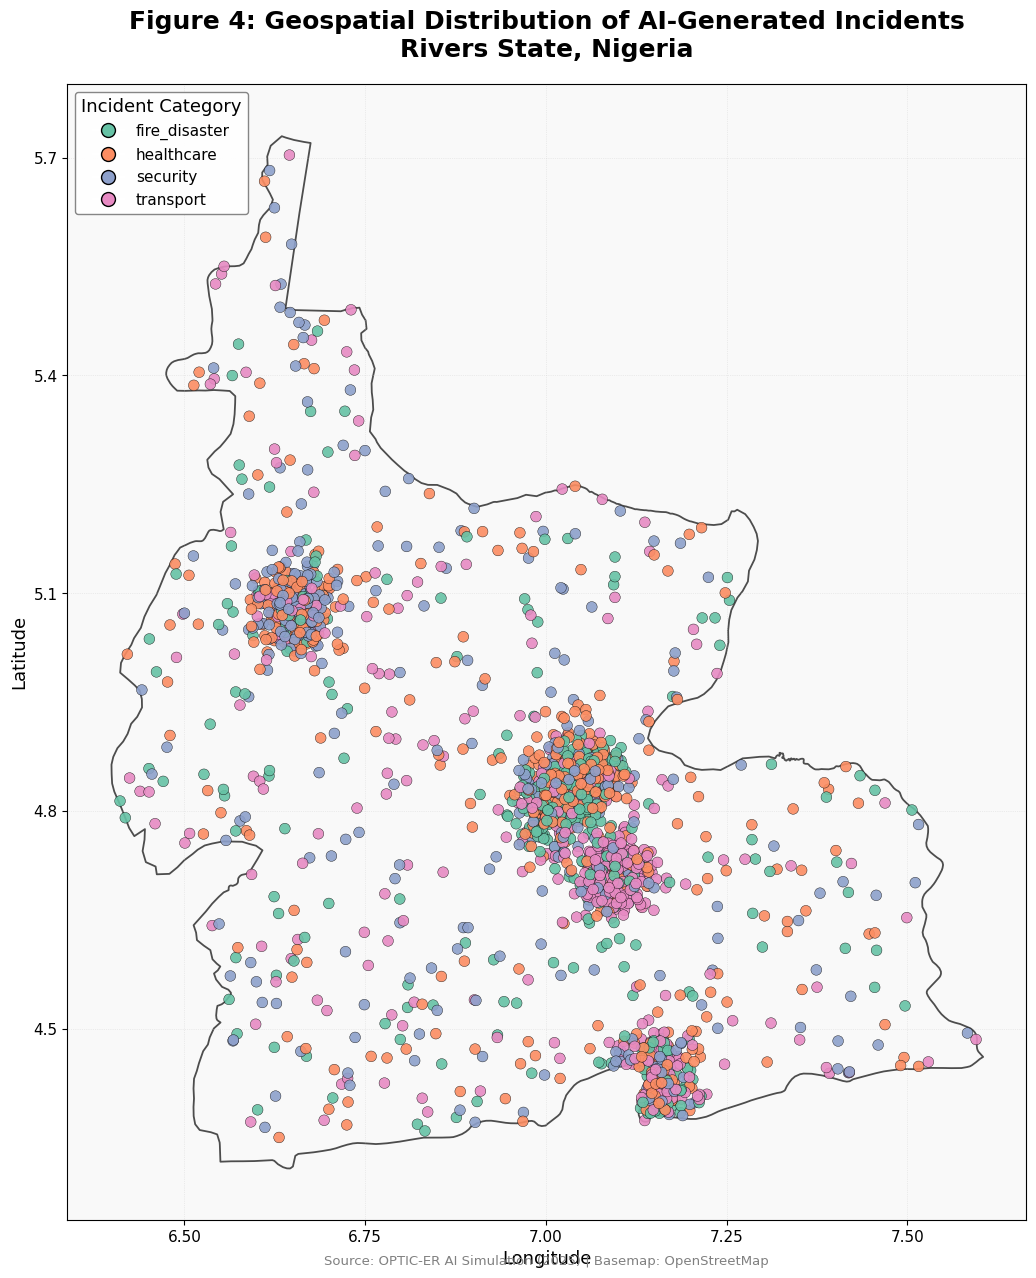

In [10]:
# =============================================================================
# OPTIC-ER | AI-Generated Incident Distribution Map
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

print("🧭 Plotting AI-Simulated Incident Distribution in Rivers State...")

# 1. Get Rivers State boundary
try:
    print("📦 Fetching boundary from OpenStreetMap...")
    rivers_state_boundary = ox.geocode_to_gdf(config.PLACE_NAME)
    print("✅ Boundary retrieved.")
except Exception as e:
    print(f"⚠️ Could not fetch boundary. Error: {e}")
    rivers_state_boundary = None

# 2. Define Colors and Style Parameters
BACKGROUND_COLOR = '#f9f9f9'
BORDER_COLOR = '#444444'
GRID_COLOR = '#cccccc'
PALETTE = sns.color_palette('Set2')  # Color-blind-friendly palette
MARKER_SIZE = 60

# 3. Create Figure
fig, ax = plt.subplots(figsize=(13, 13))
fig.patch.set_facecolor('white')

# 4. Plot Base Map
if rivers_state_boundary is not None:
    rivers_state_boundary.plot(
        ax=ax,
        facecolor=BACKGROUND_COLOR,
        edgecolor=BORDER_COLOR,
        linewidth=1.3,
        alpha=0.95,
        zorder=0
    )

# 5. Plot Incidents with Category Hue
sns.scatterplot(
    x=incidents_gdf.geometry.x,
    y=incidents_gdf.geometry.y,
    hue=incidents_gdf['category'],
    palette=PALETTE,
    s=MARKER_SIZE,
    edgecolor='black',
    linewidth=0.3,
    alpha=0.9,
    ax=ax,
    legend=False,
    zorder=2
)

# 6. Construct Custom Legend
categories = sorted(incidents_gdf['category'].unique())
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=PALETTE[i], markeredgecolor='black',
           markersize=10, label=cat)
    for i, cat in enumerate(categories)
]
ax.legend(
    handles=legend_elements,
    title='Incident Category',
    title_fontsize=13,
    fontsize=11,
    loc='upper left',
    frameon=True,
    facecolor='white',
    edgecolor='gray',
    framealpha=0.95
)

# 7. Title and Axes Formatting
ax.set_title(
    'Figure 4: Geospatial Distribution of AI-Generated Incidents\nRivers State, Nigeria',
    fontsize=18, fontweight='bold', pad=20
)
ax.set_xlabel("Longitude", fontsize=13)
ax.set_ylabel("Latitude", fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.grid(True, linestyle=':', color=GRID_COLOR, linewidth=0.5, alpha=0.6)
ax.set_facecolor(BACKGROUND_COLOR)

# 8. Axis Tick Refinement
ax.xaxis.set_major_locator(mticker.MaxNLocator(6))
ax.yaxis.set_major_locator(mticker.MaxNLocator(6))

# 9. Discreet Source Annotation
plt.annotate(
    "Source: OPTIC-ER AI Simulation (2025) | Basemap: OpenStreetMap",
    xy=(0.5, -0.04), xycoords='axes fraction',
    ha='center', fontsize=9.5, color='gray'
)

# 10. Final Layout & Display
plt.tight_layout(pad=1.5)
plt.show()

# Optional save:
fig.savefig("/content/drive/MyDrive/OpticER/data/incidents_map_MIT_standard.png", dpi=300, bbox_inches='tight')
fig.savefig("/content/drive/MyDrive/OpticER/data/incidents_map_MIT_standard.pdf", bbox_inches='tight')


In [11]:
# Count number of facilities per category
category_counts = incidents_gdf['category'].value_counts().reset_index()
category_counts.columns = ['Category', 'Number of Facilities']

# Display the count table
print(category_counts)


        Category  Number of Facilities
0     healthcare                   570
1  fire_disaster                   532
2       security                   454
3      transport                   444


In [12]:
# -----------------------------------------------------------------------------
# STEP 5: CONCLUSION
# -----------------------------------------------------------------------------
print("\n--- [5/5] Data Analysis Module Complete ---")
print("This script has successfully created and saved the following critical assets:")
print(f"  - Curated Facility Data: {CURATED_FACILITIES_PATH}")
print(f"  - Rivers State Boundary: {RIVERS_SHP_PATH}")
print(f"  - Clipped Population Map: {CLIPPED_RASTER_PATH}")
print("  - Publication-quality visualizations in the 'visuals' folder.")


--- [5/5] Data Analysis Module Complete ---
This script has successfully created and saved the following critical assets:
  - Curated Facility Data: /content/drive/MyDrive/OpticER/data/existing_facilities.geojson
  - Rivers State Boundary: /content/drive/MyDrive/OpticER/data/rivers_state.shp


NameError: name 'CLIPPED_RASTER_PATH' is not defined